In [469]:
import math 
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import pingouin as pg

In [470]:
stores = pd.read_csv("undergrad_takehome_2020.csv")
# Attributes of the stores the company operates

In [471]:
# Grouping all the months together for each store location, making it annual revenues/costs
annual_gross = stores.groupby('Location number')['Gross revenue'].sum()
annual_fixed = stores.groupby('Location number')['Fixed cost'].sum()
annual_var = stores.groupby('Location number')['Variable cost'].sum()
annual_rent = stores.groupby('Location number')['Rental cost'].sum()

profit = (annual_gross - annual_fixed - annual_var - annual_rent)

# Mean Annual Profit Margin
mean_profit = profit.mean()

# Median
median_profit = profit.median()


print('Mean Annual Profit Margin = $', round(mean_profit,2))
print('Median Annual Profit Margin = $', round(median_profit,2))

Mean Annual Profit Margin = $ 95453449.83
Median Annual Profit Margin = $ 81611260.13


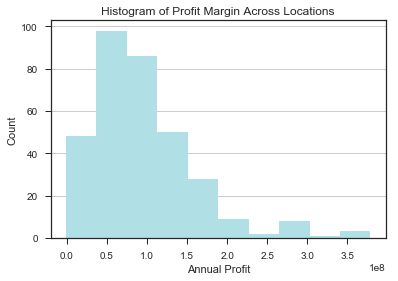

In [472]:
# Profit Margin Across Locations 
plt.hist(profit, color = 'powderblue')
plt.title('Histogram of Profit Margin Across Locations')
plt.xlabel('Annual Profit')
plt.ylabel('Count')
plt.grid(axis='y')

# The histogram does not appear to be normally distributed, it's shape is right skewed

Text(0.5,1,'Density Plot for Profit Margin')

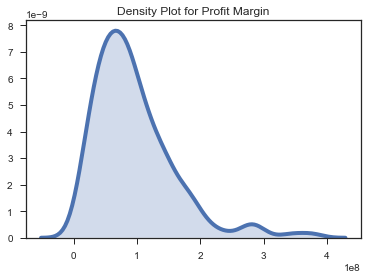

In [473]:
sns.distplot(profit, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 4}).set_title('Density Plot for Profit Margin')
# A kernel density estimation visual of the distribution with a right skew

Text(0,0.5,'Revenue')

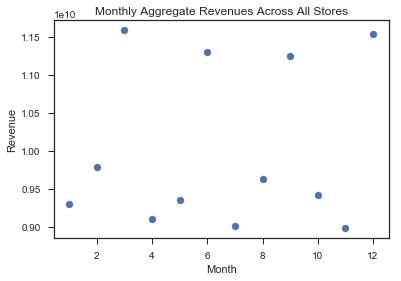

In [474]:
# Monthly Aggregate Revenue Across All Stores
# ------------------------------------------------------
monthly_gross = stores.groupby('Month')['Gross revenue'].sum()
months = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
plt.scatter(months, monthly_gross)
plt.title('Monthly Aggregate Revenues Across All Stores')
plt.xlabel('Month')
plt.ylabel('Revenue')

# As you can see the months fluctuate greatly across all stores
# March has the maximum gross revenue across all stores

Text(0,0.5,'Revenue')

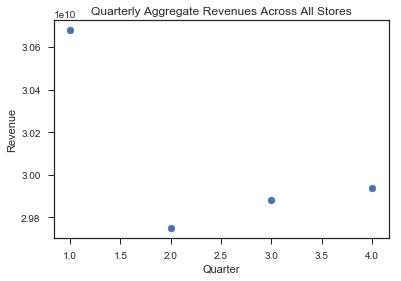

In [475]:
# Quarterly Aggregate Revenue Across All Stores
# -----------------------------------------
s = pd.Series(range(12))
N = 3
quart_gross = monthly_gross.groupby(s.index // N).sum()

quarters = np.array([1,2,3,4])
plt.scatter(quarters, quart_gross)
plt.title('Quarterly Aggregate Revenues Across All Stores')
plt.xlabel('Quarter')
plt.ylabel('Revenue')

# The first quarter's revenue is significantly greater than the rest of the quarters
# This is due to the fact that March had the highest revenue across the months

In [476]:
# The company operates both owned and leased locations
owned_stores = stores[stores.Owned == True]
rented_stores = stores[stores.Owned == False]

# The owned locations not having rental costs makes it harder to compare rented and owned locations' revenues
# Therefore we will construct a multilinear regression to predict what the rental costs for the owned locations
# would be

Text(0,0.5,'Rental Cost')

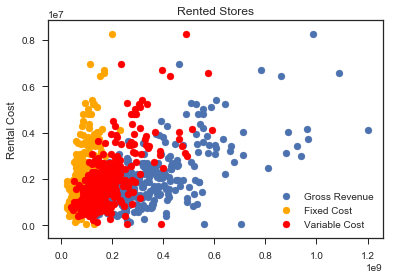

In [477]:
# Linear Relationship
# ------------------------------------------------------
# First let's check that a linear relationship exists between the dependent variable and the independent variables
r_gross = rented_stores.groupby('Location number')['Gross revenue'].sum()
r_fixed = rented_stores.groupby('Location number')['Fixed cost'].sum()
r_var = rented_stores.groupby('Location number')['Variable cost'].sum()
r_rent = rented_stores.groupby('Location number')['Rental cost'].sum()

plt.scatter(r_gross, r_rent)
plt.scatter(r_fixed,r_rent, color = 'orange')
plt.scatter(r_var, r_rent, color = 'red')
Where = ['Gross Revenue','Fixed Cost', 'Variable Cost']
plt.legend(Where,loc=4)
plt.title('Rented Stores')
plt.ylabel('Rental Cost')

# Gross revenue, fixed cost, and variable cost of the rented locations have a positive linear relationship with 
# the rental cost

Text(0.5,0,'Gross Revenue')

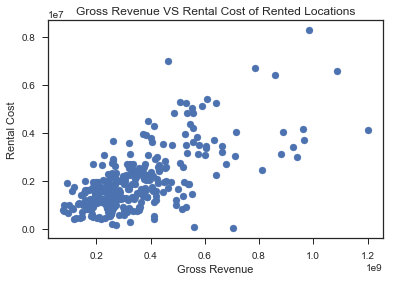

In [478]:
plt.scatter(r_gross, r_rent)
plt.title('Gross Revenue VS Rental Cost of Rented Locations')
plt.ylabel('Rental Cost')
plt.xlabel('Gross Revenue')

Text(0.5,0,'Fixed Cost')

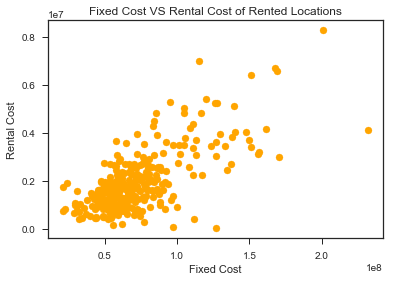

In [479]:
plt.scatter(r_fixed,r_rent, color = 'orange')
plt.title('Fixed Cost VS Rental Cost of Rented Locations')
plt.ylabel('Rental Cost')
plt.xlabel('Fixed Cost')

Text(0.5,0,'Variable Cost')

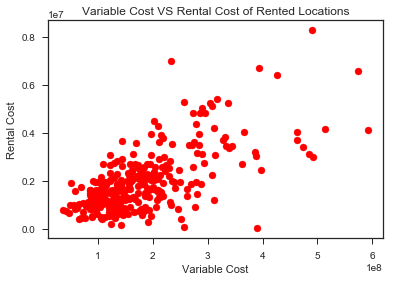

In [480]:
plt.scatter(r_var, r_rent, color = 'red')
plt.title('Variable Cost VS Rental Cost of Rented Locations')
plt.ylabel('Rental Cost')
plt.xlabel('Variable Cost')

In [481]:
# Multilinear Regression Model
# --------------------------------------------
X = rented_stores[['Gross revenue','Fixed cost','Variable cost']]
Y = rented_stores['Rental cost']

model = LinearRegression().fit(X, Y)

print('Intercept = ',model.intercept_)
print('Coefficients = ', model.coef_)

Intercept =  9244.631575385516
Coefficients =  [ 0.00096171  0.0233083  -0.00090767]


In [482]:
# Summary of Regression Results
# ----------------------------------
X = sm.add_constant(X)

mod_fit = sm.OLS(Y, X).fit()

print_model = mod_fit.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:            Rental cost   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     913.8
Date:                Tue, 17 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:59:44   Log-Likelihood:                -45279.
No. Observations:                3564   AIC:                         9.057e+04
Df Residuals:                    3560   BIC:                         9.059e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9244.6316   3468.142      2.666

In [483]:
# WATCH OUT: the variable cost coefficient's p-val is the highest and greater than 0.05 
# this means that we do not have sufficient evidence to suggest that the
#  average decrease in the variable cost corresponding to an increase in rental cost is different from zero

# Therefore we will try the model without the variable cost coefficient, and keep an eye on the gross revenue 
# p-val

In [484]:
# Multilinear Regression Model without Variable Cost
# -------------------------------------------------
X = rented_stores[['Gross revenue','Fixed cost']]
Y = rented_stores['Rental cost']

model = LinearRegression().fit(X, Y)

print('Intercept = ',model.intercept_)
print('Coefficients = ', model.coef_)

Intercept =  9359.642970603396
Coefficients =  [0.00053975 0.02303314]


In [485]:
# Summary of Regression Results
# ---------------------------------
X = sm.add_constant(X)

mod_fit = sm.OLS(Y, X).fit()

print_model = mod_fit.summary()
print(print_model)

# Now both the Gross revenue and Fixed cost coefficients' p-values are below our alpha 0.05

# The variable cost, in the previous summary, could have been causing some 
# multicollinearity 

                            OLS Regression Results                            
Dep. Variable:            Rental cost   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     1370.
Date:                Tue, 17 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:59:46   Log-Likelihood:                -45279.
No. Observations:                3564   AIC:                         9.056e+04
Df Residuals:                    3561   BIC:                         9.058e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          9359.6430   3465.242      2.701

In [486]:
# Imputing Appropriate Rental Costs for Owned Stores
# --------------------------------------------------------
stores_c = stores.copy()

# Using the linear regression equation for predicting the rental cost of a store 

for index, row in stores_c.iterrows():
    if (stores_c.loc[index,'Rental cost'] == 0):
        new_gross = stores_c.loc[index,'Gross revenue']
        new_fix = stores_c.loc[index,'Fixed cost']
        stores_c.at[index, 'Rental cost'] = model.predict([[new_gross ,new_fix]])


In [487]:
# Adjusted Annual Profit Margin
# --------------------------------------------------
# Grouping all the months together for each store location, making it annual revenues/costs
annual_gross_adj = stores_c.groupby('Location number')['Gross revenue'].sum()
annual_fixed_adj = stores_c.groupby('Location number')['Fixed cost'].sum()
annual_var_adj = stores_c.groupby('Location number')['Variable cost'].sum()
annual_rent_adj = stores_c.groupby('Location number')['Rental cost'].sum()

profit_adj = (annual_gross_adj - annual_fixed_adj - annual_var_adj - annual_rent_adj)

# Mean Annual Profit Margin
mean_profit_adj = profit_adj.mean()

# Median
median_profit_adj = profit_adj.median()


print('Mean Annual Profit Margin = $', round(mean_profit_adj,2))
print('Median Annual Profit Margin = $', round(median_profit_adj,2))

Mean Annual Profit Margin = $ 95191852.91
Median Annual Profit Margin = $ 80873817.91


In [488]:
# What is Maximizing the Profit at each Location?
# -------------------------------------------------

stores_c[stores_c['Gross revenue'] == stores_c['Gross revenue'].max()]

# Three Hypotheses:

# The Gross revenue has an affect on the profit margin

# The profit significantly varies from state to state

# The number of products at the locations affect the gross revenue

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
632,53,9,CO,118458181.3,21296086.72,58395294.37,344840,4619,False


Text(0,0.5,'Profit Margin')

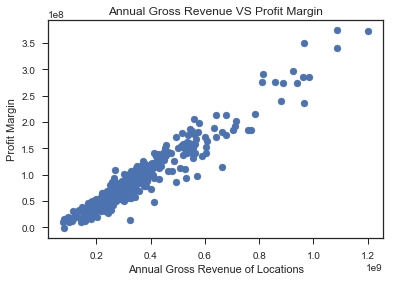

In [489]:
# Relationship between gross revenue and profit margin
# ------------------------------------------------------
plt.scatter(annual_gross_adj, profit_adj)
plt.title('Annual Gross Revenue VS Profit Margin')
plt.xlabel('Annual Gross Revenue of Locations')
plt.ylabel('Profit Margin')

# There seems to be a strong positive relationship where when Gross revenue increases, the Profit margin increases

In [490]:
# Is there a difference between the east coast and west coast profit?
# -------------------------------------------------------------------
# H0: west_coast.Gross = east_coast.Gross
# HA: west_coast.Gross != east_coast.Gross


west_coast = stores_c[(stores_c.State == 'CA') | (stores_c.State == 'WA')]
east_coast = stores_c[(stores_c.State == 'NJ') | (stores_c.State == 'GA')]

stats.ttest_ind(west_coast['Gross revenue'],east_coast['Gross revenue'])

# With a p-val of 0.2634, greater than our alpha 0.05, we fail to reject the null.
# There is not sufficient evidence to conclude that the west coast's gross revenue is different 
# than the east coast's

Ttest_indResult(statistic=1.1186011183745879, pvalue=0.2634478419870094)

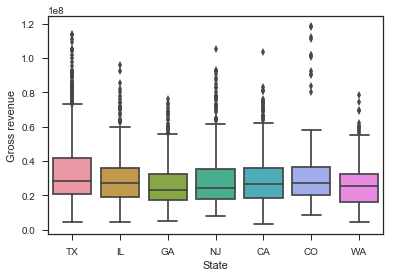

In [491]:
# How does the Gross revenue vary from state to state?
# -------------------------------------------------------
sns.boxplot(x="State", y="Gross revenue", data=stores_c)

# The median Gross revenue of the states appear to be relatively close but the outliers span a
# larger range. Could this be significant?

In [492]:
# H0: TX.gross = IL.gross = .... = WA.gross
# HA: TX.gross != IL.gross != .... != WA.gross
aov = pg.anova(data=stores_c, dv='Gross revenue', between='State', detailed=True)
print(aov)

# with a p-val of 2.91551e-21, less than our alpha 0.05, we have sufficient evidence to conclude that 
# the gross revenue is different on avg from state to state

   Source            SS    DF            MS       F        p-unc    np2
0   State  2.959875e+16     6  4.933124e+15  18.452  2.91551e-21  0.027
1  Within  1.066460e+18  3989  2.673502e+14       -            -      -


In [493]:
pt = pg.pairwise_tukey(dv='Gross revenue', between='State', data=stores_c)
print(pt)

# The states that vary significantly are:
# CA and TX
# CO and GA
# GA and TX
# IL and WA
# NJ and TX
# TX and WA

     A   B       mean(A)       mean(B)         diff           se       tail  \
0   CA  CO  2.865364e+07  3.253558e+07 -3881946.034  1356066.546  two-sided   
1   CA  GA  2.865364e+07  2.637727e+07  2276365.251   875337.191  two-sided   
2   CA  IL  2.865364e+07  2.910709e+07  -453454.966   875337.191  two-sided   
3   CA  NJ  2.865364e+07  2.965733e+07 -1003696.709  1024627.821  two-sided   
4   CA  TX  2.865364e+07  3.369802e+07 -5044381.194   757775.513  two-sided   
5   CA  WA  2.865364e+07  2.704792e+07  1605721.814  1394635.369  two-sided   
6   CO  GA  3.253558e+07  2.637727e+07  6158311.284  1377626.984  two-sided   
7   CO  IL  3.253558e+07  2.910709e+07  3428491.068  1377626.984  two-sided   
8   CO  NJ  3.253558e+07  2.965733e+07  2878249.324  1476991.225  two-sided   
9   CO  TX  3.253558e+07  3.369802e+07 -1162435.161  1306087.530  two-sided   
10  CO  WA  3.253558e+07  2.704792e+07  5487667.848  1754037.833  two-sided   
11  GA  IL  2.637727e+07  2.910709e+07 -2729820.217 

Text(0.5,0,'Number of products')

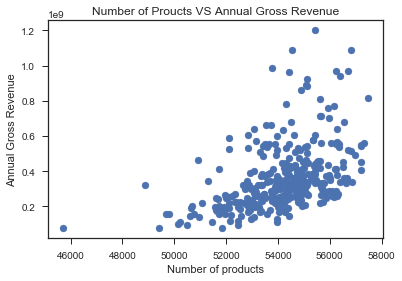

In [494]:
# What makes some states vary from others?
# Maybe there is a relationship between number of products a store has and the gross revenue
# --------------------------------------------------------------------------------------------
num_products = stores_c.groupby('Location number')['Number of products'].sum()
plt.scatter(num_products, annual_gross_adj)
plt.title('Number of Proucts VS Annual Gross Revenue')
plt.ylabel('Annual Gross Revenue')
plt.xlabel('Number of products')

# The scatterplot appears exponential, to make it more linear we will apply log to the gross revenue

Text(0.5,0,'Number of products')

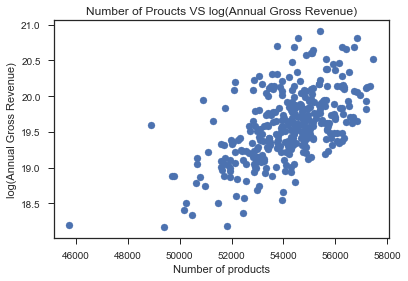

In [495]:
num_products = stores_c.groupby('Location number')['Number of products'].sum()
plt.scatter(num_products, np.log(annual_gross_adj))
plt.title('Number of Proucts VS log(Annual Gross Revenue)')
plt.ylabel('log(Annual Gross Revenue)')
plt.xlabel('Number of products')

# Now the relationship appears to be positive and linear

In [496]:
# Linear Regression Analysis
# --------------------------------------------------------
X = np.array(stores_c['Number of products']).reshape(-1,1)
Y = stores_c['Gross revenue']

model = LinearRegression().fit(X, Y)

print('Intercept = ',model.intercept_)
print('Coefficients = ', model.coef_)

# log(Gross) = 55281.51(Number of Products) - 219281906.78
# Gross = e^55281.51(Number of Products) - 219281906.78

Intercept =  -219281906.7838589
Coefficients =  [55281.50792664]


In [497]:
X = sm.add_constant(X)

mod_fit = sm.OLS(Y, X).fit()

print_model = mod_fit.summary()
print(print_model)

# The coefficients p_val is less than our alpha 0.05, therefore we have sufficient 
# evidence to conclude that as number of products increases so does log(Gross revenue)

                            OLS Regression Results                            
Dep. Variable:          Gross revenue   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     1021.
Date:                Tue, 17 Sep 2019   Prob (F-statistic):          1.17e-199
Time:                        09:59:58   Log-Likelihood:                -71639.
No. Observations:                3996   AIC:                         1.433e+05
Df Residuals:                    3994   BIC:                         1.433e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.193e+08   7.81e+06    -28.081      0.0